In [1]:
# ! pip install pricing-analysis-utils==0.15.1

In [2]:
%load_ext autoreload
%autoreload 2

# Shipper Guide Bids analysis

For Shipper Guide, each Spot Quote can have:

- multiple bids with different rates
- multiple carriers bidding
- the same carrier bidding multiple times

This is a wealth of data and opportunity and we might ask, based on the info at hand, what is the best bid to accept? Or what is the best bid to give?

The bellow is a simple analysis of the data at hand. It is not meant to be a complete analysis, but rather a starting point for further analysis.

We will start by loading the data and doing some cleaning.

We will look at all quotes with more than 1 bid with price and a few things.


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from pricing_analysis_utils.db import read_cached_sql

df = read_cached_sql(open("queries/sg_bids_spot.sql").read(), use_trino=True)

2023-08-10 14:36:33,146	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 
INFO:root:Reading from cache (sql_cache/73dc9812_trino.parquet)...
INFO:root:Fetched 116352 rows.


In [5]:
df

,sqr_quote_created,spot_quote_id,rate_id,rate_date,quote_status,quote_booked,quote_type,shipper,mode,equipment_type,...,tender_accepted_at,tender_lead_time_min,time_to_book_min,tendered_to,tender_carrier_id,origin_type,loadsmart_ref_number,load_channel,shipment_status,total_stops
0,2023-01-31 20:51:31,115850,857239,2023-02-01 01:51:32.378,expired,0,free_quote,Steer Sourcing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
1,2023-01-31 20:52:51,115851,857241,2023-02-01 01:52:51.493,expired,0,free_quote,Steer Sourcing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
2,2023-02-01 00:01:03,115880,857420,2023-02-01 05:01:03.496,expired,0,free_quote,Kwick kargo llc,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
3,2023-02-01 06:54:42,115915,857542,2023-02-01 11:54:42.815,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
4,2023-02-01 06:54:42,115915,857544,2023-02-01 11:55:44.486,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116347,2023-08-09 16:10:53,306564,2720244,2023-08-09 20:10:53.799,quoting,0,free_quote,Cargo Sprout Inc,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
116348,2023-08-09 16:15:44,306571,2720406,2023-08-09 20:15:44.458,quoting,0,free_quote,R-DTNA,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
116349,2023-08-09 16:17:48,306574,2720479,2023-08-09 20:17:48.959,quoting,0,free_quote,safeco,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
116350,2023-08-09 16:17:55,306575,2720480,2023-08-09 20:17:55.049,quoting,0,free_quote,safeco,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2


In [6]:
df = df[df["flat_rate"] > 1]

In [7]:
print(
    f"We have {df.spot_quote_id.unique().shape[0]} unique quotes and {df.shape[0]} unique bids"
)

We have 72775 unique quotes and 116352 unique bids


In [8]:
df.loc[df.total_rates_provided == 1, "rate_carrier_name"].value_counts()

Loadsmart (Spot)                                        65974
Jb Hunt Over The Road Asset Team                           25
Jb Hunt Intermodal 53’                                     20
Rg Transport Usda / Spot Quotes                            16
Sajacks Transport Inc                                      14
Us Multimodal Logistics 40' Intermodal Rates               10
Schneider National Carriers Over The Road Asset Team        8
Tql Brokerage Team                                          7
D & L Transport Llc                                         7
Direct Connect Logistix Inc                                 4
Silo                                                        3
Boss Logistics Llc                                          3
Tru-Way Logistics Llc                                       3
Schneider National Intermodal                               3
Red Gold Transport Inbound                                  3
Renaissance Transport                                       2
Buchanan

Most of the quotes with one bid is only bids provided by Loadsmart, which makes sense because we bid automatically for most spot quotes in ShipperGuide.

## Looking at quotes with multiple bids

We are interested in the case where we have multiple bids.


In [9]:
print(
    f"Out of these, only {df[df.total_rates_provided > 1].spot_quote_id.unique().shape[0]} quotes "
    f"had more than a single valid bid, which is {round(100*df[df.total_rates_provided > 1].spot_quote_id.unique().shape[0]/df.spot_quote_id.unique().shape[0],2)}% "
    f"of the total number of quotes."
)

Out of these, only 6667 quotes had more than a single valid bid, which is 9.16% of the total number of quotes.


In [10]:
print(
    f"And looking at bids, {df[df.total_rates_provided > 1].shape[0]} bids "
    f"were in quotes with more than a single valid bid, which is {round(100*df[df.total_rates_provided > 1].shape[0]/df.shape[0],2)}% "
    f"of the total number of bids."
)

And looking at bids, 50238 bids were in quotes with more than a single valid bid, which is 43.18% of the total number of bids.


Text(0.5, 0, 'Number of Rates')

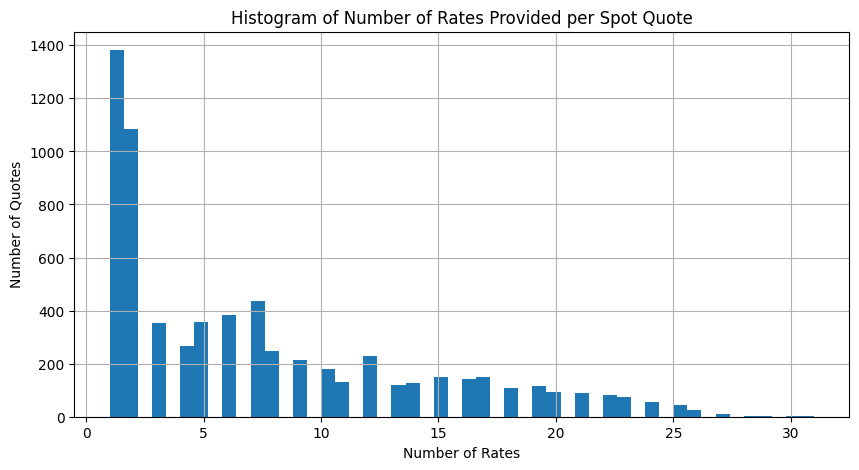

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

df[(df.total_rates_provided > 1) & (df.flat_rate > 1)].groupby("spot_quote_id").agg(
    {"rate_id": "nunique"}
).hist(bins=50, ax=ax)

ax.set_title("Histogram of Number of Rates Provided per Spot Quote")
ax.set_ylabel("Number of Quotes")
ax.set_xlabel("Number of Rates")

As we can see above, most quotes with more than 1 bid have 2 or 3 bids, but we also have a non-negligible number of quotes with 4 or more bids, and a rather long tailed distribution.

---

## Looking at bid position

We want to see if there's a significant change in the rates offered depending if the bid is one of the first ones or not.


In [12]:
df["rpm"] = df["flat_rate"] / df["mileage"]
df["rate_over_ls"] = df["flat_rate"] / df["ls_rate"]
df["rate_over_avg"] = df["flat_rate"] / df["avg_rates"]

df["is_loadsmart"] = df["rate_carrier_name"].str.lower().str.contains("loadsmart")

Text(0.5, 1.0, 'Carrier Rate over LS Rate by Bid Position in % (0% is first and 100% is last)')

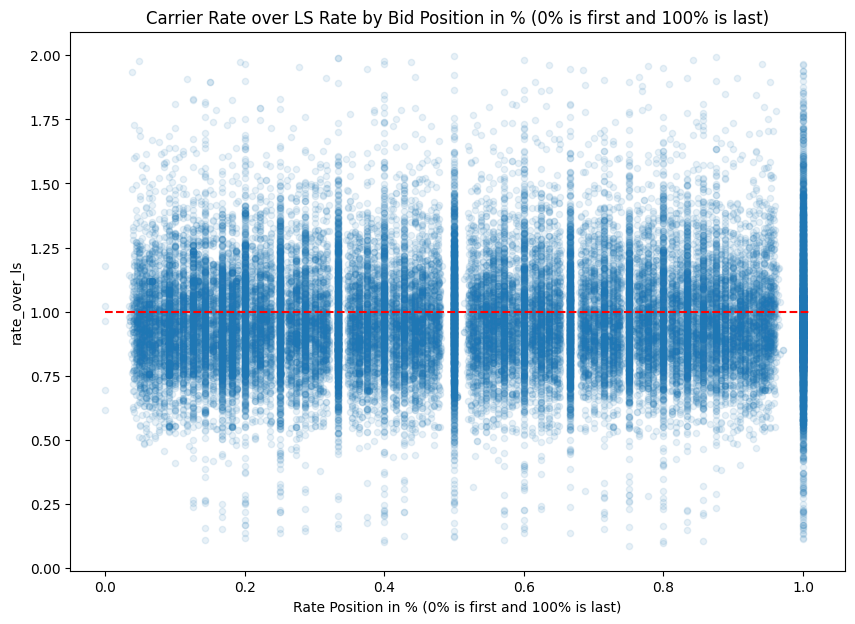

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

df[
    (df.total_rates_provided > 1)
    & (df.flat_rate < 5000)
    & (df.mileage > 1)
    & (~df["is_loadsmart"])
    & (df.rate_over_ls < 2)
].plot.scatter(x="rate_pct_pos", y="rate_over_ls", alpha=0.1, ax=ax)

ax.hlines(1, 0, 1.01, color="red", linestyle="dashed")
ax.set_xlabel("Rate Position in % (0% is first and 100% is last)")
ax.set_title(
    "Carrier Rate over LS Rate by Bid Position in % (0% is first and 100% is last)"
)

There's no relation that latter bids are cheaper than LS bids or not.


Text(0.5, 1.0, 'Carrier Rate over Avg Rate by Rate Position in % (0% is first and 100% is last)')

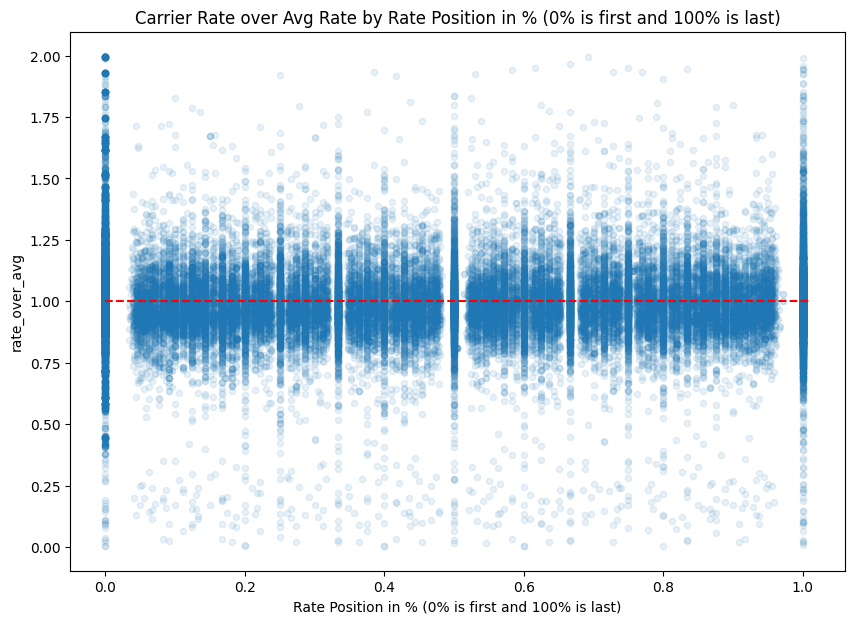

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

df[
    (df.total_rates_provided > 1)
    & (df.flat_rate < 5000)
    & (df.mileage > 1)
    & (df.rate_over_avg < 2)
].plot.scatter(x="rate_pct_pos", y="rate_over_avg", alpha=0.1, ax=ax)

ax.hlines(1, 0, 1.01, color="red", linestyle="dashed")
ax.set_xlabel("Rate Position in % (0% is first and 100% is last)")
ax.set_title(
    "Carrier Rate over Avg Rate by Rate Position in % (0% is first and 100% is last)"
)

There's no relation that latter bids are cheaper than the Average rate or not.

So we can conclude that the rate position isn't related to the bid price.


## Analyzing some variables

If the bid is within 1% of the minimum RPM, we can consider it to be the lowest bid.

This is so we can compare the bids that are similarly low without rounding errors.

We also look at


In [15]:
df["min_rpm"] = df["min_rate"] / df["mileage"]

df["is_lowest_rate"] = df["rpm"] <= (df["min_rpm"] * 1.01)

df["is_lower_than_avg"] = df["flat_rate"] < df["avg_rates"]

In [16]:
data = df.loc[df["total_rates_provided"] > 1, :]

print(
    f"Out of all the bids considered, only: \n"
    f"  - {round(100*data['is_lowest_rate'].sum() / data.shape[0],2)}% is the lowest rate\n"
    f"  - {round(100*data['is_lower_than_avg'].sum() / data.shape[0],2)}% is lower than the average\n"
    f"  - {round(100*data['is_booked_bid'].sum() / data.shape[0],2)}% is booked without rejection\n"
)

Out of all the bids considered, only: 
  - 14.02% is the lowest rate
  - 53.03% is lower than the average
  - 6.29% is booked without rejection



For a given universe where we have 2 or more rates provided, only 8.7% of the rates provided are near the lowest rate. We want to give the probability of the rate given being the lowest rate.


In [17]:
mask = data["flat_rate"] > 1

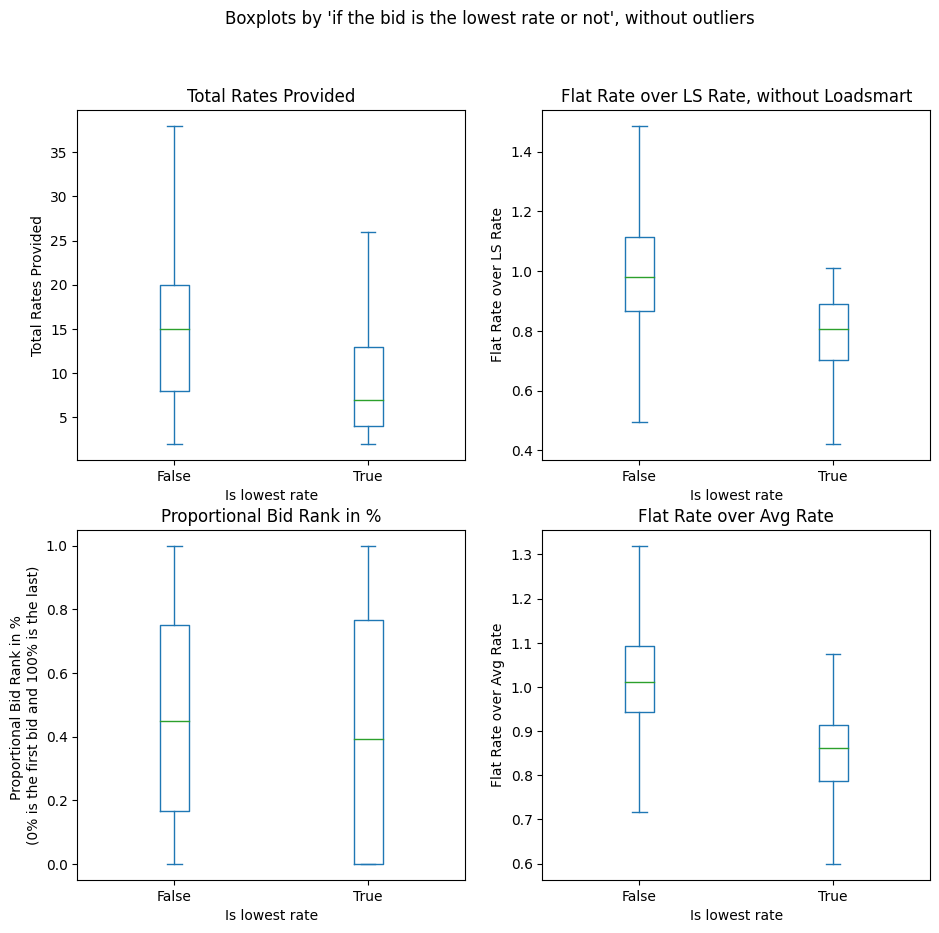

In [18]:
from utils import plot_boxplots

plot_boxplots(
    data, mask, by="is_lowest_rate", description="if the bid is the lowest rate or not"
)

Looking at the blox plots, we can see that the lowest rates are :

1. slightly more skewed to the earliest bids
2. Lower than LS rates, with a median at 80% of LS Rates
3. Lower than the avg rates, with a median of under 90% of the avg rate


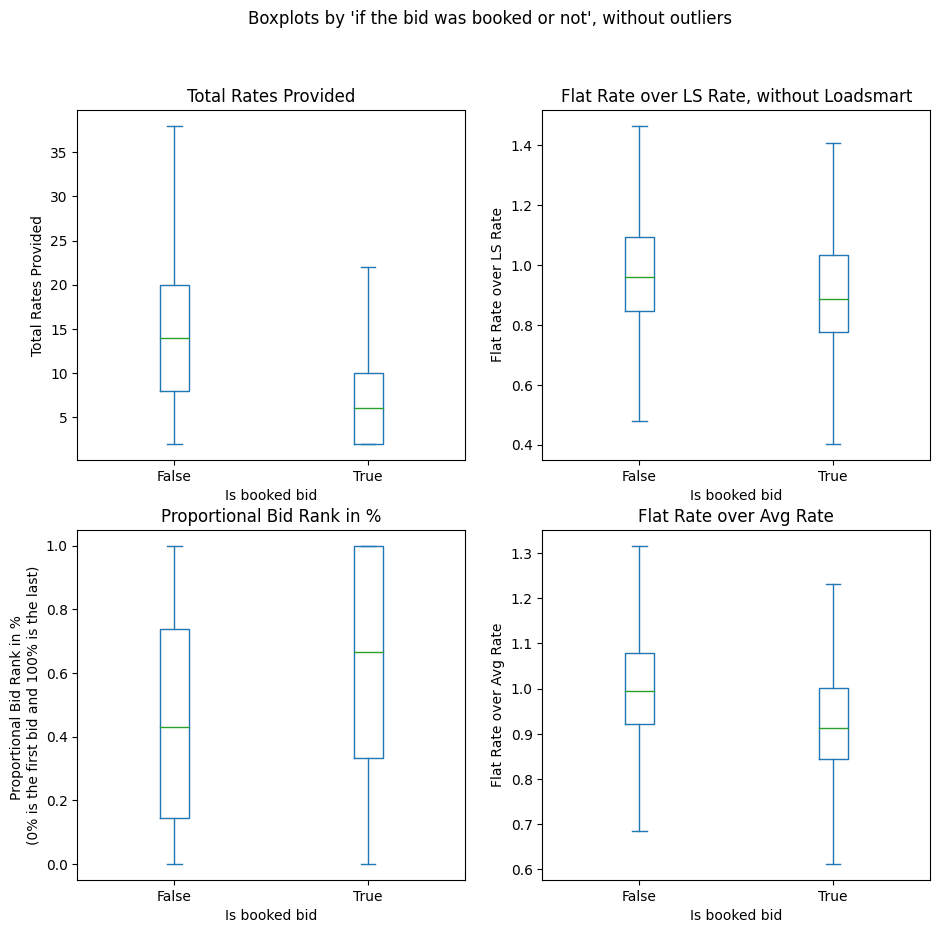

In [19]:
plot_boxplots(data, mask, "is_booked_bid", "if the bid was booked or not")

Interestingly, we can see that the bids aren't the similar to the lowest rates, they are:

1. skewed to the latest bids
2. Only slightly lower than LS rates, with a median at 90% of LS Rates
3. Only slightly skewed lower than the Avg Rate, with a median of 90% of the avg rate

This means that having a smaller rate isn't that corretlated to win the bid. Maybe other factors are more important, such as if the carrier is trusted or not.


In [20]:
booked_lowest = data.groupby("is_lowest_rate").agg({"quote_booked": ["count", "sum"]})
booked_lowest / data.shape[0]

quote_booked          
                      count       sum
is_lowest_rate                       
False              0.859827  0.414208
True               0.140173  0.083244

In [21]:
booked_lowest["proportion_booked"] = (
    booked_lowest["quote_booked"]["sum"] / booked_lowest["quote_booked"]["count"]
)
booked_lowest

quote_booked        proportion_booked
                      count    sum                  
is_lowest_rate                                      
False                 43196  20809          0.481734
True                   7042   4182          0.593865

In [22]:
print(
    f"As we can see, being the lowest rate increases the odds of booking only by {round(100*(booked_lowest.iloc[1,2]/booked_lowest.iloc[0,2] -1),2) }%"
)

As we can see, being the lowest rate increases the odds of booking only by 23.28%


## Making features

### Quote related

The features below are related to:

- Location
- Pickup and delivery times


In [23]:
from utils import (
    geo_features,
    date_features,
    datetime_to_features,
    lead_time_features,
    rate_features,
)

data = geo_features(data)
data = date_features(data)
data = datetime_to_features(data, "pickup_date")
data = datetime_to_features(data, "delivery_date")
data = datetime_to_features(data, "sqr_quote_created")

In [24]:
data = lead_time_features(data)

### Bid related

The features below are related to the bid/rate, they include:

- Time of the bid (rate time) and leadtime
- Bid price and past bid prices and volumes for the quote


In [25]:
data = datetime_to_features(data, "rate_date")
data = lead_time_features(data)
data = data.reset_index(drop=True)
data = rate_features(data)

In [28]:
data

,sqr_quote_created,spot_quote_id,rate_id,rate_date,quote_status,quote_booked,quote_type,shipper,mode,equipment_type,...,flat_rate_mean,flat_rate_std,flat_rate_median,flat_rate_min,flat_rate_max,flat_rate_count,rate_above_mean,rate_above_median,rate_is_currently_lowest,rate_is_currently_high
0,2023-02-01 06:54:42,115915,857542,2023-02-01 11:54:42.815,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,2339.100000,NaN,2339.10,2339.10,2339.10,1.0,False,False,True,True
1,2023-02-01 06:54:42,115915,857544,2023-02-01 11:55:44.486,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,2344.550000,7.707464,2344.55,2339.10,2350.00,2.0,True,True,False,True
2,2023-02-01 06:54:42,115915,857545,2023-02-01 11:55:44.882,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,2326.366667,31.962530,2339.10,2290.00,2350.00,3.0,False,False,True,False
3,2023-02-01 06:54:42,115915,857547,2023-02-01 11:55:44.946,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,2282.275000,91.963956,2314.55,2150.00,2350.00,4.0,False,False,True,False
4,2023-02-01 06:54:42,115915,857549,2023-02-01 11:55:45.009,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,2311.820000,103.477350,2339.10,2150.00,2430.00,5.0,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50233,2023-08-09 16:02:36,306552,2720134,2023-08-09 20:02:37.431,booked,1,free_quote,Yamaha Managed,FTL,DRV,...,949.700000,NaN,949.70,949.70,949.70,1.0,False,False,True,True
50234,2023-08-09 16:04:22,306554,2720155,2023-08-09 20:04:23.431,booked,1,free_quote,Yamaha Managed,FTL,DRV,...,949.700000,NaN,949.70,949.70,949.70,1.0,False,False,True,True
50235,2023-08-09 16:06:01,306555,2720163,2023-08-09 20:06:01.552,booked,1,free_quote,Yamaha Managed,FTL,DRV,...,835.450000,NaN,835.45,835.45,835.45,1.0,False,False,True,True
50236,2023-08-09 16:08:03,306557,2720170,2023-08-09 20:08:04.104,booked,1,free_quote,Yamaha Managed,FTL,DRV,...,960.860000,NaN,960.86,960.86,960.86,1.0,False,False,True,True


In [27]:
data.to_parquet("data/features.parquet")

## Last Words

The features created above are straightforward to come by as they should be present at the time of the bidding transaction.

However, we should be aware that most of the data will need to be sent by the ShipperGuide system and this is still an
unkown for our team.
